In [43]:
import argparse
import glob
import numpy as np
import os
import time
import cv2
import torch
import matplotlib.pyplot as plt
import random
import math
from skimage.metrics import structural_similarity as ssim
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, AffineTransform
# Suppress the specific warning
import warnings
import csv
import sys
from IPython.utils.capture import capture_output
from datetime import datetime

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

# Jet colormap for visualization.
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])


# SuperPoint

In [44]:
class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    return semi, desc


class SuperPointFrontend(object):
  """ Wrapper around pytorch net to help with pre and post image processing. """
  def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
               cuda=False):
    self.name = 'SuperPoint'
    self.cuda = cuda
    self.nms_dist = nms_dist
    self.conf_thresh = conf_thresh
    self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
    self.cell = 8 # Size of each output cell. Keep this fixed.
    self.border_remove = 4 # Remove points this close to the border.

    # Load the network in inference mode.
    self.net = SuperPointNet()
    if cuda:
      # Train on GPU, deploy on GPU.
      self.net.load_state_dict(torch.load(weights_path))
      self.net = self.net.cuda()
    else:
      # Train on GPU, deploy on CPU.
      self.net.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
    self.net.eval()

  def nms_fast(self, in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T
  
    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.
  
    Grid Value Legend:
    -1 : Kept.
     0 : Empty or suppressed.
     1 : To be processed (converted to either kept or supressed).
  
    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.
  
    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds

  def run(self, img):
    """ Process a numpy image to extract points and descriptors.
    Input
      img - HxW numpy float32 input image in range [0,1].
    Output
      corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      desc - 256xN numpy array of corresponding unit normalized descriptors.
      heatmap - HxW numpy heatmap in range [0,1] of point confidences.
      """
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    H, W = img.shape[0], img.shape[1]
    inp = img.copy()
    inp = (inp.reshape(1, H, W))
    inp = torch.from_numpy(inp)
    inp = torch.autograd.Variable(inp).view(1, 1, H, W)
    if self.cuda:
      inp = inp.cuda()
    # Forward pass of network.
    outs = self.net.forward(inp)
    semi, coarse_desc = outs[0], outs[1]
    # Convert pytorch -> numpy.
    semi = semi.data.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / self.cell)
    Wc = int(W / self.cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell])
    xs, ys = np.where(heatmap >= self.conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = self.border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    # --- Process descriptor.
    D = coarse_desc.shape[1]
    if pts.shape[1] == 0:
      desc = np.zeros((D, 0))
    else:
      # Interpolate into descriptor map using 2D point locations.
      samp_pts = torch.from_numpy(pts[:2, :].copy())
      samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
      samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
      samp_pts = samp_pts.transpose(0, 1).contiguous()
      samp_pts = samp_pts.view(1, 1, -1, 2)
      samp_pts = samp_pts.float()
      if self.cuda:
        samp_pts = samp_pts.cuda()
      desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts, align_corners=True)
      desc = desc.data.cpu().numpy().reshape(D, -1)
      desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc, heatmap


class PointTracker(object):
  """ Class to manage a fixed memory of points and descriptors that enables
  sparse optical flow point tracking.

  Internally, the tracker stores a 'tracks' matrix sized M x (2+L), of M
  tracks with maximum length L, where each row corresponds to:
  row_m = [track_id_m, avg_desc_score_m, point_id_0_m, ..., point_id_L-1_m].
  """

  def __init__(self, max_length, nn_thresh):
    if max_length < 2:
      raise ValueError('max_length must be greater than or equal to 2.')
    self.maxl = max_length
    self.nn_thresh = nn_thresh
    self.all_pts = []
    for n in range(self.maxl):
      self.all_pts.append(np.zeros((2, 0)))
    self.last_desc = None
    self.tracks = np.zeros((0, self.maxl+2))
    self.track_count = 0
    self.max_score = 9999

  def nn_match_two_way(self, desc1, desc2, nn_thresh):
    """
    Performs two-way nearest neighbor matching of two sets of descriptors, such
    that the NN match from descriptor A->B must equal the NN match from B->A.

    Inputs:
      desc1 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      desc2 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      nn_thresh - Optional descriptor distance below which is a good match.

    Returns:
      matches - 3xL numpy array, of L matches, where L <= N and each column i is
                a match of two descriptors, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, match_score]^T
    """
    assert desc1.shape[0] == desc2.shape[0]
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
      return np.zeros((3, 0))
    if nn_thresh < 0.0:
      raise ValueError('\'nn_thresh\' should be non-negative')
    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2-2*np.clip(dmat, -1, 1))
    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    # Threshold the NN matches.  <<< ======================= this threshold is not good
    keep = scores < nn_thresh
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    # Get the surviving point indices.
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    # Populate the final 3xN match data structure.
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    return matches
  
  def ransac(self, points1, points2, matches, max_reproj_error=5.0):  # <<=========================================== TODO Here is the RANSAC
    '''find matching points between two images using RANSAC'''
    
    # estimate affine transform model using all coordinates
    model = AffineTransform()
    model.estimate(points1, points2)

    # try min_samples = 3, if fail, try min_samples = 2
    try:
      # Find the best fundamental matrix using RANSAC
      best_model, best_inliers = ransac((points1, points2),
                                        AffineTransform, min_samples=3,
                                        residual_threshold=max_reproj_error, max_trials=100)
    except:
      try:
        best_model, best_inliers = ransac((points1, points2),
                                          AffineTransform, min_samples=2,
                                          residual_threshold=max_reproj_error, max_trials=100)
        
      except:
        # if ransac failed, return an array of TRUE with the original matches shape
        print('ransac failed')
        print('matches shape: ', matches.shape)
        return np.ones((matches.shape[1])).astype(bool)
    
    # the inliners are the matching points
    matches = np.array(best_inliers).T

    # print(f'matches: {matches.shape}')
    return matches

  def get_offsets(self):
    """ Iterate through list of points and accumulate an offset value. Used to
    index the global point IDs into the list of points.

    Returns
      offsets - N length array with integer offset locations.
    """
    # Compute id offsets.
    offsets = []
    offsets.append(0)
    for i in range(len(self.all_pts)-1): # Skip last camera size, not needed.
      offsets.append(self.all_pts[i].shape[1])
    offsets = np.array(offsets)
    offsets = np.cumsum(offsets)
    return offsets

  def update(self, pts, desc):
    """ Add a new set of point and descriptor observations to the tracker.

    Inputs
      pts - 3xN numpy array of 2D point observations.
      desc - DxN numpy array of corresponding D dimensional descriptors.
    """
    if pts is None or desc is None:
      print('PointTracker: Warning, no points were added to tracker.')
      return
    assert pts.shape[1] == desc.shape[1]
    # Initialize last_desc.
    if self.last_desc is None:
      self.last_desc = np.zeros((desc.shape[0], 0))
    # Remove oldest points, store its size to update ids later.
    remove_size = self.all_pts[0].shape[1]
    self.all_pts.pop(0)
    self.all_pts.append(pts)
    # Remove oldest point in track.
    self.tracks = np.delete(self.tracks, 2, axis=1)
    # Update track offsets.
    for i in range(2, self.tracks.shape[1]):
      self.tracks[:, i] -= remove_size
    self.tracks[:, 2:][self.tracks[:, 2:] < -1] = -1
    offsets = self.get_offsets()
    # Add a new -1 column.
    self.tracks = np.hstack((self.tracks, -1*np.ones((self.tracks.shape[0], 1))))
    # Try to append to existing tracks.
    matched = np.zeros((pts.shape[1])).astype(bool)
    matches = self.nn_match_two_way(self.last_desc, desc, self.nn_thresh)
    for match in matches.T:
      # Add a new point to it's matched track.
      id1 = int(match[0]) + offsets[-2]
      id2 = int(match[1]) + offsets[-1]
      found = np.argwhere(self.tracks[:, -2] == id1)
      if found.shape[0] > 0:
        matched[int(match[1])] = True
        row = int(found)
        self.tracks[row, -1] = id2
        if self.tracks[row, 1] == self.max_score:
          # Initialize track score.
          self.tracks[row, 1] = match[2]
        else:
          # Update track score with running average.
          # NOTE(dd): this running average can contain scores from old matches
          #           not contained in last max_length track points.
          track_len = (self.tracks[row, 2:] != -1).sum() - 1.
          frac = 1. / float(track_len)
          self.tracks[row, 1] = (1.-frac)*self.tracks[row, 1] + frac*match[2]
    # Add unmatched tracks.
    new_ids = np.arange(pts.shape[1]) + offsets[-1]
    new_ids = new_ids[~matched]
    new_tracks = -1*np.ones((new_ids.shape[0], self.maxl + 2))
    new_tracks[:, -1] = new_ids
    new_num = new_ids.shape[0]
    new_trackids = self.track_count + np.arange(new_num)
    new_tracks[:, 0] = new_trackids
    new_tracks[:, 1] = self.max_score*np.ones(new_ids.shape[0])
    self.tracks = np.vstack((self.tracks, new_tracks))
    self.track_count += new_num # Update the track count.
    # Remove empty tracks.
    keep_rows = np.any(self.tracks[:, 2:] >= 0, axis=1)
    self.tracks = self.tracks[keep_rows, :]
    # Store the last descriptors.
    self.last_desc = desc.copy()
    return

  def get_tracks(self, min_length):
    """ Retrieve point tracks of a given minimum length.
    Input
      min_length - integer >= 1 with minimum track length
    Output
      returned_tracks - M x (2+L) sized matrix storing track indices, where
        M is the number of tracks and L is the maximum track length.
    """
    if min_length < 1:
      raise ValueError('\'min_length\' too small.')
    valid = np.ones((self.tracks.shape[0])).astype(bool)
    good_len = np.sum(self.tracks[:, 2:] != -1, axis=1) >= min_length
    # Remove tracks which do not have an observation in most recent frame.
    not_headless = (self.tracks[:, -1] != -1)
    keepers = np.logical_and.reduce((valid, good_len, not_headless))
    returned_tracks = self.tracks[keepers, :].copy()
    return returned_tracks

  def draw_tracks(self, out, tracks):
    """ Visualize tracks all overlayed on a single image.
    Inputs
      out - numpy uint8 image sized HxWx3 upon which tracks are overlayed.
      tracks - M x (2+L) sized matrix storing track info.
    """
    # Store the number of points per camera.
    pts_mem = self.all_pts
    N = len(pts_mem) # Number of cameras/images.
    # Get offset ids needed to reference into pts_mem.
    offsets = self.get_offsets()
    # Width of track and point circles to be drawn.
    stroke = 1
    # Iterate through each track and draw it.
    for track in tracks:
      clr = myjet[int(np.clip(np.floor(track[1]*10), 0, 9)), :]*255
      for i in range(N-1):
        if track[i+2] == -1 or track[i+3] == -1:
          continue
        offset1 = offsets[i]
        offset2 = offsets[i+1]
        idx1 = int(track[i+2]-offset1)
        idx2 = int(track[i+3]-offset2)
        pt1 = pts_mem[i][:2, idx1]
        pt2 = pts_mem[i+1][:2, idx2]
        p1 = (int(round(pt1[0])), int(round(pt1[1])))
        p2 = (int(round(pt2[0])), int(round(pt2[1])))
        cv2.line(out, p1, p2, clr, thickness=stroke, lineType=16)
        # Draw end points of each track.
        if i == N-2:
          clr2 = (255, 0, 0)
          cv2.circle(out, p2, stroke, clr2, -1, lineType=16)

  def read_image(self, impath, img_size):
    """ Read image as grayscale and resize to img_size.
    Inputs
      impath: Path to input image.
      img_size: (W, H) tuple specifying resize size.
    Returns
      grayim: float32 numpy array sized H x W with values in range [0, 1].
    """
    grayim = cv2.imread(impath, 0)
    if grayim is None:
      raise Exception('Error reading image %s' % impath)
    # Image is resized via opencv.
    interp = cv2.INTER_AREA
    grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)
    grayim = (grayim.astype('float32') / 255.)
    return grayim

  def next_frame(self):
    """ Return the next frame, and increment internal counter.
    Returns
       image: Next H x W image.
       status: True or False depending whether image was loaded.
    """
    if self.i == self.maxlen:
      return (None, False)
    if self.camera:
      ret, input_image = self.cap.read()
      if ret is False:
        print('VideoStreamer: Cannot get image from camera (maybe bad --camid?)')
        return (None, False)
      if self.video_file:
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.listing[self.i])
      input_image = cv2.resize(input_image, (self.sizer[1], self.sizer[0]),
                               interpolation=cv2.INTER_AREA)
      input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
      input_image = input_image.astype('float')/255.0
    else:
      image_file = self.listing[self.i]
      input_image = self.read_image(image_file, self.sizer)
    # Increment internal counter.
    self.i = self.i + 1
    input_image = input_image.astype('float32')
    return (input_image, True)
  

# Plotting

In [45]:
# Function to overlay points on the image
def overlay_points(image, points, color=(0, 255, 0), radius=5):
    for point in points.T:
        x, y = int(point[0]), int(point[1])
        cv2.circle(image, (x, y), radius, color, -1)
    return image

# Predefined bright colors
bright_colors = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 255, 0),  # Yellow
    (0, 255, 255),  # Cyan
    (255, 0, 255),  # Magenta
    (255, 128, 0),  # Orange
    (0, 255, 128),  # Spring Green
    (128, 0, 255),  # Purple
    (255, 0, 128),  # Rose
]

# Function to draw lines connecting points from image 1 to image 2 with random bright colors
def draw_lines(image1, image2, points1, points2, match, line_thickness=1, opacity=0.5):
    # Convert grayscale images to 3-channel with repeated intensity value
    if len(image1.shape) == 2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    if len(image2.shape) == 2:
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    combined_image = np.concatenate((image1, image2), axis=1)
    for pt1, pt2, value in zip(points1.T, points2.T, match):
        x1, y1 = int(pt1[0]), int(pt1[1])
        x2, y2 = int(pt2[0] + image1.shape[1]), int(pt2[1])

        # Randomly choose a color from the predefined bright colors
        line_color = random.choice(bright_colors)

        # Draw the line with the chosen color and specified thickness
        cv2.line(combined_image, (x1, y1), (x2, y2), line_color, line_thickness)

        # Add lines with the chosen color and opacity on top of the combined image
        overlay = combined_image.copy()
        cv2.line(overlay, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.addWeighted(overlay, opacity, combined_image, 1 - opacity, 0, combined_image)

        # Add value from 'match' array as text around the beginning of the line on the left image
        value_text = f"{value:.2f}"
        text_x = x1 - 50 if x1 > 50 else x1 + 10
        text_y = y1 + 15
        cv2.putText(combined_image, value_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, line_color, 1)

    return combined_image

# function to draw lines connecting original points and the transformed points with random bright colors on one image
def draw_lines_one_image(image, points1, points2, line_thickness=1, opacity=0.5, line_color=None):
    # Convert grayscale images to 3-channel with repeated intensity value
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for pt1, pt2 in zip(points1.T, points2.T):
        x1, y1 = int(pt1[0]), int(pt1[1])
        x2, y2 = int(pt2[0]), int(pt2[1])

        # If not specified, randomly choose a color from the predefined bright colors
        if line_color is None:
            line_color = random.choice(bright_colors)

        # Draw the line with the chosen color and specified thickness
        cv2.line(image, (x1, y1), (x2, y2), line_color, line_thickness)

        # Add lines with the chosen color and opacity on top of the combined image
        overlay = image.copy()
        cv2.line(overlay, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.addWeighted(overlay, opacity, image, 1 - opacity, 0, image)

        # show the distance between the two points (MSE)
        '''value = np.mean((pt1 - pt2)**2)
        value_text = f"{value:.2f}"
        text_x = x1 - 50 if x1 > 50 else x1 + 10
        text_y = y1 + 15
        cv2.putText(image, value_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, line_color, 1)'''
        
    return image

# Function to create a heatmap from keypoints
def create_heatmap(image, keypoints, size=5, sigma=1):
    heatmap = np.zeros_like(image)
    for kp in keypoints.T:
        x, y = int(kp[0]), int(kp[1])
        heatmap[y - size:y + size + 1, x - size:x + size + 1] = 1
    heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=sigma, sigmaY=sigma)
    return heatmap

# Function to create a checkerboard image of image1 and image2 with 10x10 squares
def create_checkerboard(image1, image2):
    checkerboard = np.zeros((512, 512))
    # Create the checkerboard pattern
    width = 512

    tile_size = width / 10
    for i in range(checkerboard.shape[0]):
        for j in range(checkerboard.shape[1]):
            num = (math.floor(i / tile_size) + math.floor(j / tile_size)) % 2
            if num == 0:
                checkerboard[i, j] = image1[i, j]
            else:
                checkerboard[i, j] = image2[i, j]

    return checkerboard

def check_location(points):
    # check if the location of the points in array is within the image
    # return the number of points that are outside the image
    # points is a 2D array of shape (2, N)
    # where N is the number of points
    # the first row is the x coordinate
    # the second row is the y coordinate
    # the image size is 512 x 512
    # the points are assumed to be in the range of 0 to 511
    # return the number of points that are outside the image
    number_outside = np.sum((points < 0) | (points > 511))
    
    # print if there are points outside the image
    if number_outside > 0:
        print(f'Number of points outside the image: {number_outside}')
    # return number_outside

def load_images_from_folder(folder, img_size=(512, 512)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        grayim = cv2.imread(img_path, 0)
        interp = cv2.INTER_AREA
        grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)
        image = (grayim.astype('float32') / 255.)
        if image is not None:
            images.append(image)
    return images

def RANSAC_affine_plot(name, dir_name, image1_name, image1, image2, 
                       points1, points2, desc1, desc2, heatmap1, heatmap2, plot=True):
    # input both matches from RANSAC and non-RANSAC to affine_transform
    # because we have to create affine transform matrix from matches_RANSAC
    # and apply it to matches1 and matches2
    # display them on the image with different colors
    print('Affine_plot')

    # Part 1 - RANSAC
    # match the points between the two images
    tracker = PointTracker(5, nn_thresh=0.7)
    matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=0.7)

    # take the elements from points1 and points2 using the matches as indices
    matches1 = points1[:2, matches[0, :].astype(int)]
    matches2 = points2[:2, matches[1, :].astype(int)]

    # MSE and TRE before transformation
    mse_before = np.mean((matches1 - matches2)**2)
    tre_before = np.mean(np.sqrt(np.sum((matches1 - matches2)**2, axis=0)))
    
    # create affine transform matrix from points1 to points2
    # and apply it to points1
    affine_transform1 = cv2.estimateAffinePartial2D(matches1.T, matches2.T)
    print(f'Affine transform matrix from points1 to points2:\n{affine_transform1[0]}')
    matches1_transformed = cv2.transform(matches1.T[None, :, :], affine_transform1[0])
    matches1_transformed = matches1_transformed[0].T

    mse12 = np.mean((matches1_transformed - matches2)**2)
    tre12 = np.mean(np.sqrt(np.sum((matches1_transformed - matches2)**2, axis=0)))

    # create affine transform matrix from points2 to points1
    # and apply it to points2
    affine_transform2 = cv2.estimateAffinePartial2D(matches2[:2, :].T, matches1[:2, :].T)
    print(f'Affine transform matrix from points2 to points1:\n{affine_transform2[0]}')
    matches2_transformed = cv2.transform(matches2.T[None, :, :], affine_transform2[0])
    matches2_transformed = matches2_transformed[0].T

    mse21 = np.mean((matches2_transformed - matches1)**2)
    tre21 = np.mean(np.sqrt(np.sum((matches2_transformed - matches1)**2, axis=0)))

    # transform image 1 and 2 using the affine transform matrix
    image1_transformed = cv2.warpAffine(image1, affine_transform1[0], (512, 512))
    image2_transformed = cv2.warpAffine(image2, affine_transform2[0], (512, 512))

    # calculate the MSE between image1_transformed and image2
    mse12_image = np.mean((image1_transformed - image2)**2)
    # calculate the MSE between image2_transformed and image1
    mse21_image = np.mean((image2_transformed - image1)**2)

    ssim_before = ssim(image1, image2, data_range=image1.max() - image1.min())
    # calculate SSIM between image1_transformed and image2
    ssim12_image = ssim(image1_transformed, image2, data_range=image1_transformed.max() - image1_transformed.min())
    # calculate SSIM between image2_transformed and image1
    ssim21_image = ssim(image2_transformed, image1, data_range=image2_transformed.max() - image2_transformed.min())

    # Part 3 - Plotting
    if plot:
        # Create a subplot with 2 rows and 2 columns
        fig, axes = plt.subplot_mosaic("AAFE;BDCG", figsize=(20, 10))

        overlaid1 = overlay_points(image1.copy(), matches1, radius=2)
        overlaid2 = overlay_points(image2.copy(), matches2, radius=2)
        overlaid1_transformed = overlay_points(image1_transformed.copy(), matches1_transformed, radius=2)
        overlaid2_transformed = overlay_points(image2_transformed.copy(), matches2_transformed, radius=2)
        
        # Row 1: Two images side-by-side with overlaid points and lines
        # show also MSE and SSIM between the two images
        axes["A"].imshow(draw_lines(overlaid1, overlaid2, matches1, matches2, matches[2, :]))
        axes["A"].set_title(f"Pair {image1_name} with matched points. MSE (x100): {100*np.mean((image1 - image2)**2):.4f} SSIM (x10): {10*ssim_before:.4f}")
        axes["A"].axis('off')

        axes["B"].imshow(overlaid1_transformed, cmap='gray')
        axes["B"].set_title(f"Image A transformed to B")
        axes["B"].axis('off')

        axes["C"].imshow(overlaid2_transformed, cmap='gray')
        axes["C"].set_title(f"Image B transformed to A")
        axes["C"].axis('off')

        # New subplot for histograms of 'match_score' array
        '''axes["D"].hist(match_score, bins=20, color='blue', alpha=0.3)
        axes["D"].set_title(f"Match Score Histogram, {len(match_score)} matches")
        axes["D"].set_xlabel("Value")
        axes["D"].set_ylabel("Frequency")'''

        # New subplot for the transformed points
        # Blue: from original locations from image 2/1 to the affine-transformed locations
        # Red: from affine-transformed locations of points from image 2/1 to 
        # the locations they supposed to be in image 1/2
        img2 = draw_lines_one_image(overlaid2, matches1_transformed, matches1, line_color=(0, 0, 155))
        img2 = draw_lines_one_image(img2, matches2, matches1_transformed, line_color=(255, 0, 0))
        axes["F"].imshow(img2)
        axes["F"].set_title(f"Image B with points A transformed to B. MSE: {mse12:.4f}")
        axes["F"].axis('off')
        
        img1 = draw_lines_one_image(overlaid1, matches2_transformed, matches2, line_color=(0, 0, 155))
        img1 = draw_lines_one_image(img1, matches1, matches2_transformed, line_color=(255, 0, 0))
        axes["E"].imshow(img1)
        axes["E"].set_title(f"Image A with points B transformed to A. MSE: {mse21:.4f}")
        axes["E"].axis('off')        

        # Display the checkerboard image 1 transformed to 2
        checkerboard = create_checkerboard(overlaid1_transformed, overlaid2)
        axes["D"].imshow(checkerboard, cmap='gray')
        axes["D"].set_title(f"Checkerboard A to B: {mse12_image:.4f}")
        axes["D"].axis('off')

        # Display the checkerboard image 2 transformed to 1
        checkerboard = create_checkerboard(overlaid2_transformed, overlaid1)
        axes["G"].imshow(checkerboard, cmap='gray')
        axes["G"].set_title(f"Checkerboard B to A: {mse21_image:.4f}")
        axes["G"].axis('off')
        
        plt.tight_layout()  # Adjust the layout to leave space for the histogram
        # create a folder named as yyyy-mm-dd_hh in output_images folder      
        plt.savefig(os.path.join(dir_name, f"{image1_name}_normal.png"))
        
        # save images to output folder
        '''cv2.imwrite(f"../Dataset/output_images/transformed_images/{image1_name}_{image2_name}_{name}_1.png", image1_transformed*255)
        cv2.imwrite(f"../Dataset/output_images/transformed_images/{image1_name}_{image2_name}_{name}_2.png", image2_transformed*255)'''
        plt.close()


    print('RANSAC_affine_plot')
    matches_RANSAC = tracker.ransac(matches1.T, matches2.T, matches, max_reproj_error=2)
            
    # take elements from matches1 and matches2 where matches_RANSAC is TRUE
    matches_RANSAC = matches_RANSAC.reshape(-1)
    matches1_RANSAC = matches1[:, matches_RANSAC]
    matches2_RANSAC = matches2[:, matches_RANSAC]
    print(f'{matches1_RANSAC.shape}, {matches2_RANSAC.shape}')

    '''# take elements from matches1 and matches2 where matches_RANSAC is FALSE
    matches1_outliers = matches1[:2, ~matches_RANSAC]
    matches2_outliers = matches2[:2, ~matches_RANSAC]
    # print(f'outliers: {matches1_outliers.shape}, {matches2_outliers.shape}')'''

    # Part 2 - Affine Transform
    # create affine transform matrix from points1 to points2 and apply it to points1
    # also from points2 to points1 and apply it to points2
    # points1 and points2 are 2D arrays of shape (2, N)
    # where N is the number of points
    # the first row is the x coordinate
    # the second row is the y coordinate
    # the image size is 512 x 512

    #################################### FIX THIS ####################################
    # create affine transform matrix using only matches_RANSAC
    # and apply it to all points, plot all first, then plot RANSAC over it
    affine_transform1 = cv2.estimateAffinePartial2D(matches1_RANSAC.T, matches2_RANSAC.T)
    print(f'Affine transform matrix from points1 to points2:\n{affine_transform1[0]}')
    matches1_all_transformed = cv2.transform(matches1.T[None, :, :], affine_transform1[0], (512, 512))
    matches1_all_transformed = matches1_all_transformed[0].T

    matches1_inliers_transformed = matches1_all_transformed[:, matches_RANSAC]

    # create affine transform matrix from points2 to points1
    # and apply it to all points, plot all first, then plot RANSAC over it
    affine_transform2 = cv2.estimateAffinePartial2D(matches2_RANSAC.T, matches1_RANSAC.T)
    print(f'Affine transform matrix from points2 to points1:\n{affine_transform2[0]}')
    matches2_all_transformed = cv2.transform(matches2.T[None, :, :], affine_transform2[0], (512, 512))
    matches2_all_transformed = matches2_all_transformed[0].T

    matches2_inliers_transformed = matches2_all_transformed[:, matches_RANSAC]

    #################################### Metrics for points ####################################
        
    # calculate the MSE between points1_transformed and points2
    mse12_RANSAC = np.mean((matches1_all_transformed - matches2)**2)
    tre12_RANSAC = np.mean(np.sqrt(np.sum((matches1_all_transformed - matches2)**2, axis=0)))

    # calculate the MSE between points2_transformed and points1
    mse21_RANSAC = np.mean((matches2_all_transformed - matches1)**2)
    tre21_RANSAC = np.mean(np.sqrt(np.sum((matches2_all_transformed - matches1)**2, axis=0)))

    #################################### Metrics for images ####################################
    # transform image 1 and 2 using the affine transform matrix
    image1_transformed = cv2.warpAffine(image1, affine_transform1[0], (512, 512))
    image2_transformed = cv2.warpAffine(image2, affine_transform2[0], (512, 512))

    # calculate the MSE between image1_transformed and image2
    mse12_image_RANSAC = np.mean((image1_transformed - image2)**2)
    # calculate the MSE between image2_transformed and image1
    mse21_image_RANSAC = np.mean((image2_transformed - image1)**2)

    # calculate SSIM between image1_transformed and image2
    ssim12_image_RANSAC = ssim(image1_transformed, image2, data_range=image1_transformed.max() - image1_transformed.min())
    # calculate SSIM between image2_transformed and image1
    ssim21_image_RANSAC = ssim(image2_transformed, image1, data_range=image2_transformed.max() - image2_transformed.min())

    # take the match score of the elements in matches_RANSAC to plot with lines
    match_score = matches[2, matches_RANSAC]

    # Part 3 - Plotting
    if plot:
        # Create a subplot with 2 rows and 2 columns
        fig, axes = plt.subplot_mosaic("AAFE;BDCG", figsize=(20, 10))

        overlaid1 = overlay_points(image1.copy(), matches1, radius=2)
        overlaid2 = overlay_points(image2.copy(), matches2, radius=2)
        overlaid1_transformed = overlay_points(image1_transformed.copy(), matches1_all_transformed, radius=2)
        overlaid2_transformed = overlay_points(image2_transformed.copy(), matches2_all_transformed, radius=2)
        
        # Row 1: Two images side-by-side with overlaid points and lines
        # show also MSE and SSIM between the two images
        axes["A"].imshow(draw_lines(overlaid1, overlaid2, matches1_RANSAC, matches2_RANSAC, match_score))
        axes["A"].set_title(f"(RANSAC) Pair {image1_name} with matched points. MSE (x100): {100*np.mean((image1 - image2)**2):.4f} SSIM (x10): {10*ssim_before:.4f}")
        axes["A"].axis('off')

        axes["B"].imshow(overlaid1_transformed, cmap='gray')
        axes["B"].set_title(f"Image A transformed to B")
        axes["B"].axis('off')
        
        axes["C"].imshow(overlaid2_transformed, cmap='gray')
        # axes["C"].imshow(image2_transformed, cmap='gray')
        axes["C"].set_title(f"Image B transformed to A")
        axes["C"].axis('off')

        # New subplot for the transformed points
        # Blue: from original locations from image 2/1 to the affine-transformed locations
        # Red: from affine-transformed locations of points from image 2/1 to 
        # the locations they supposed to be in image 1/2 (Non-RANSAC)
        # Green: from affine-transformed locations of points from image 2/1 to 
        # the locations they supposed to be in image 1/2 (Non-RANSAC)

        # image 2 with lines connecting RANSAC inliers and outliers in different colors
        img2 = draw_lines_one_image(overlaid2, matches1_all_transformed, matches1, line_color=(0, 0, 155))
        img2 = draw_lines_one_image(img2, matches2, matches1_all_transformed, line_color=(255, 0, 0))
        img2 = draw_lines_one_image(img2, matches1_inliers_transformed, matches1_RANSAC, line_color=(0, 255, 0))
        # img2 = draw_lines_one_image(img2, matches2_RANSAC, matches1_inliers_transformed, line_color=(0, 255, 0))

        axes["F"].imshow(img2)
        axes["F"].set_title(f"Image B with points A transformed to B. MSE: {mse12_RANSAC:.4f}")
        axes["F"].axis('off')

        img1 = draw_lines_one_image(overlaid1, matches2_all_transformed, matches2, line_color=(0, 0, 155)) # color: blue
        img1 = draw_lines_one_image(img1, matches1, matches2_all_transformed, line_color=(255, 0, 0))
        img1 = draw_lines_one_image(img1, matches2_inliers_transformed, matches2_RANSAC, line_color=(0, 255, 0)) # RANSAC inliers
        # img1 = draw_lines_one_image(img1, matches1_RANSAC, matches2_inliers_transformed, line_color=(0, 255, 0)) # RANSAC inliers
        
        axes["E"].imshow(img1)
        axes["E"].set_title(f"Image A with points B transformed to A. MSE: {mse21_RANSAC:.4f}")
        axes["E"].axis('off')

        # Display the checkerboard image 1 transformed to 2
        # checkerboard = create_checkerboard(image1_transformed, image2)
        checkerboard = create_checkerboard(overlaid1_transformed, overlaid2)
        axes["D"].imshow(checkerboard, cmap='gray')
        axes["D"].set_title(f"Checkerboard A to B: {mse12_image_RANSAC:.4f}")
        axes["D"].axis('off')

        # Display the checkerboard image 2 transformed to 1
        # checkerboard = create_checkerboard(image2_transformed, image1)
        checkerboard = create_checkerboard(overlaid2_transformed, overlaid1)
        axes["G"].imshow(checkerboard, cmap='gray')
        axes["G"].set_title(f"Checkerboard B to A: {mse21_image_RANSAC:.4f}")
        axes["G"].axis('off')
        
        plt.tight_layout()  # Adjust the layout to leave space for the histogram
        plt.savefig(os.path.join(dir_name, f"{image1_name}_RANSAC.png"))
        plt.close()

    return matches1_transformed.shape[-1], mse_before, mse12, mse21, tre_before, tre12, tre21, mse12_image, mse21_image, ssim12_image, ssim21_image, \
        matches1_inliers_transformed.shape[-1], mse12_RANSAC, mse21_RANSAC, tre12_RANSAC, tre21_RANSAC, mse12_image_RANSAC, mse21_image_RANSAC, ssim12_image_RANSAC, ssim21_image_RANSAC


# Load data

In [46]:
import pandas as pd

# read csv file to get the image names
df = pd.read_csv('dataset_reg_pair_filled.csv')

In [47]:
# take the rows that 'training' = 1 as testing data
df_test = df[df['training'] == 1]
df_test.head()

,Directory,Source image,Source ROI,Target image,Target ROI,training,Warped target images,Warped target ROI,Execution time
0,Dataset/Dataset-processed/15-12-2559/2011248/Lb,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b1.jpg,NaN,1,NaN,NaN,NaN
1,Dataset/Dataset-processed/15-12-2559/2011248/Lb,2011248_20161215__L_b2.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN
2,Dataset/Dataset-processed/15-12-2559/2011248/Lb,2011248_20161215__L_b1.jpg,NaN,2011248_20161215__L_b3.jpg,NaN,1,NaN,NaN,NaN
638,Dataset/Dataset-processed/06-10-2560/c2,01102560_6.jpg,NaN,17092560_4.jpg,NaN,1,NaN,NaN,NaN
664,Dataset/Dataset-processed/30-12-2559/2477598/b,2477598_20161230__R_b3.jpg,NaN,2477598_20161230__R_b1.jpg,NaN,1,NaN,NaN,NaN


In [48]:
df_test['Directory'].iloc[0][3:]

'aset/Dataset-processed/15-12-2559/2011248/Lb'

In [49]:
# load images
def load_image(img_path, img_size=(512, 512)):
    grayim = cv2.imread(img_path, 0)
    interp = cv2.INTER_AREA
    grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)

    # normalize image to range 0 to 1
    image = (grayim/np.max(grayim)).astype('float32')

    return image

# Run

In [50]:
# main function for testing 2 methods and calculate the MSE, TRE, and SSIM
def main_test(weights_path='superpoint_v1.pth', cuda=True, print_output=False):
    # print if cuda is available
    if cuda:
        print('CUDA is available')
    else:
        print('CUDA is not available')

    # Initialize SuperPointFrontend
    superpoint = SuperPointFrontend(weights_path, nms_dist=4,
                          conf_thresh=0.015,
                          nn_thresh=0.7, cuda=cuda)
    
    # list to store image metrics (MSE, SSIM - before and after)
    mse_image_before_list = []
    mse_after12_list = []
    mse_after21_list = []
    mse_after12_RANSAC_list = []
    mse_after21_RANSAC_list = []
    ssim_before_list = []
    ssim_after12_list = []
    ssim_after21_list = []
    ssim_after12_RANSAC_list = []
    ssim_after21_RANSAC_list = []
    
    # create a list to store the MSE, TRE values
    mse_before_list = []
    mse12_list = []
    mse21_list = []
    mse12_RANSAC_list = []
    mse21_RANSAC_list = []
    tre_before_list = []
    tre12_list = []
    tre21_list = []
    tre12_RANSAC_list = []
    tre21_RANSAC_list = []

    # create a dataframe to store the metrics
    df_metrics = pd.DataFrame(columns=['ID', 'Image 1', 'Image 2', 'MSE before', \
            'MSE 1 to 2', 'MSE 2 to 1', 'TRE before', 'TRE 1 to 2', 'TRE 2 to 1', 'MSE before image', 'MSE 1 to 2 image', \
            'MSE 2 to 1 image', 'SSIM before', 'SSIM 1 to 2 image', 'SSIM 2 to 1 image', 'number of points', \
            'MSE 1 to 2 RANSAC', 'MSE 2 to 1 RANSAC', 'TRE 1 to 2 RANSAC', 'TRE 2 to 1 RANSAC', 'MSE 1 to 2 image RANSAC', \
            'MSE 2 to 1 image RANSAC', 'SSIM 1 to 2 image RANSAC', 'SSIM 2 to 1 image RANSAC', 'number of points RANSAC'])
    
    # Save the current sys.stdout
    original_stdout = sys.stdout

    # Create a folder named as yyyy-mm-dd_hh in output_images folder
    dirname = f"../results/{datetime.now().strftime('%Y-%m-%d_%H')+'_actual'}"
    os.makedirs(dirname, exist_ok=True)

    # Define a file where you want to save the print statements
    output_file = os.path.join(dirname, 'output.txt')
    # if the file is already there, delete it
    if os.path.exists(output_file):
        os.remove(output_file)
    
    i = 0
    # load images from df_test
    for index, row in df_test.iterrows():
        print(f'\nRow {i}: {row["Directory"]}, {row["Source image"]}, {row["Target image"]}')
        image1 = load_image(os.path.join(row['Directory'], row['Source image']))
        image2 = load_image(os.path.join(row['Directory'], row['Target image']))

        # Process the first image
        points1, desc1, heatmap1 = superpoint.run(image1)

        # Process the second image
        points2, desc2, heatmap2 = superpoint.run(image2)

        # calculate image similarity before transformation
        mse_image_before_list.append(np.mean((image1 - image2)**2))
        ssim_before = ssim(image1, image2, data_range=image1.max() - image1.min())
        ssim_before_list.append(ssim_before)

        if print_output:
            # RANSAC, Affine Transform, Plotting in one function
            number_points, mse_before, mse12, mse21, tre_before, tre12, tre21, mse12_image, mse21_image, ssim12_image, ssim21_image, \
                number_points_RANSAC, mse12_RANSAC, mse21_RANSAC, tre12_RANSAC, tre21_RANSAC, mse12_image_RANSAC, mse21_image_RANSAC, \
                    ssim12_image_RANSAC, ssim21_image_RANSAC = RANSAC_affine_plot(
                    'actual', dirname, i, image1, image2, points1, points2, desc1, desc2, heatmap1, heatmap2, plot=True)

        else:
            try: # need to do this because the warning cannot be suppressed, fix clipping makes the image all black
                # Open the file in append mode to save the print statements
                with open(output_file, 'a') as file:
                    # Redirect sys.stdout to the file
                    sys.stdout = file
                    print(f'Row {i}: {row["Directory"]}, {row["Source image"]}, {row["Target image"]}')

                    # Redirect warnings to the file
                    # warnings.filterwarnings('always')  # Capture all warnings
                    warnings_file = open(output_file, 'a')
                    warnings.showwarning = lambda message, category, filename, lineno, file=warnings_file, line=None: \
                        file.write(warnings.formatwarning(message, category, filename, lineno, line))
                    
                    with capture_output():
                        number_points, mse_before, mse12, mse21, tre_before, tre12, tre21, mse12_image, mse21_image, ssim12_image, ssim21_image, \
                            number_points_RANSAC, mse12_RANSAC, mse21_RANSAC, tre12_RANSAC, tre21_RANSAC, mse12_image_RANSAC, mse21_image_RANSAC, \
                                ssim12_image_RANSAC, ssim21_image_RANSAC = RANSAC_affine_plot(
                                'actual', dirname, i, image1, image2, points1, points2, desc1, desc2, heatmap1, heatmap2, plot=True)
                    
                    # After the code execution, restore sys.stdout to its original value
                    sys.stdout = original_stdout

                    # Close the warnings file
                    warnings_file.close()

            except Exception as e:
                # Handle exceptions, if any
                print(f"An error occurred: {e}")
        
        # calculate statistics
        mse_before_list.append(mse_before)
        tre_before_list.append(tre_before)
        mse12_list.append(mse12)
        mse21_list.append(mse21)
        tre12_list.append(tre12)
        tre21_list.append(tre21)
        mse_after12_list.append(mse12_image)
        mse_after21_list.append(mse21_image)
        ssim_after12_list.append(ssim12_image)
        ssim_after21_list.append(ssim21_image)
        
        mse12_RANSAC_list.append(mse12_RANSAC)
        mse21_RANSAC_list.append(mse21_RANSAC)
        tre12_RANSAC_list.append(tre12_RANSAC)
        tre21_RANSAC_list.append(tre21_RANSAC)
        mse_after12_RANSAC_list.append(mse12_image_RANSAC)
        mse_after21_RANSAC_list.append(mse21_image_RANSAC)
        ssim_after12_RANSAC_list.append(ssim12_image_RANSAC)
        ssim_after21_RANSAC_list.append(ssim21_image_RANSAC)

        # append the metrics to the dataframe
        df_metrics = pd.concat([df_metrics, pd.DataFrame(data={'ID': i, 'Image 1': row['Source image'], 'Image 2': row['Target image'], \
            'MSE before': mse_before, 'MSE 1 to 2': mse12, 'MSE 2 to 1': mse21, 'TRE before': tre_before, \
            'TRE 1 to 2': tre12, 'TRE 2 to 1': tre21, 'MSE before image': np.mean((image1 - image2)**2), 'MSE 1 to 2 image': mse12_image, \
            'MSE 2 to 1 image': mse21_image, 'SSIM before': ssim_before, 'SSIM 1 to 2 image': ssim12_image, 'SSIM 2 to 1 image': ssim21_image, \
            'number of points': number_points, 'MSE 1 to 2 RANSAC': mse12_RANSAC, 'MSE 2 to 1 RANSAC': mse21_RANSAC, \
            'TRE 1 to 2 RANSAC': tre12_RANSAC, 'TRE 2 to 1 RANSAC': tre21_RANSAC, 'MSE 1 to 2 image RANSAC': mse12_image_RANSAC, \
            'MSE 2 to 1 image RANSAC': mse21_image_RANSAC, 'SSIM 1 to 2 image RANSAC': ssim12_image_RANSAC, \
            'SSIM 2 to 1 image RANSAC': ssim21_image_RANSAC, 'number of points RANSAC': number_points_RANSAC}, index=[i])])

        i += 1
        if i > 50:
            break

    # print the average MSE
    print('\nNon-RANSAC:')
    print('Landmark points:')
    print(f'Average MSE before transformation: {np.mean(mse_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse12_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse21_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse12_list + mse21_list):.4f}')
    # print TRE before transformation
    print(f'Average TRE before transformation: {np.mean(tre_before_list):.4f}')
    # print TRE after transformation
    print(f'Average TRE for image 1 transformed to image 2: {np.mean(tre12_list):.4f}')
    print(f'Average TRE for image 2 transformed to image 1: {np.mean(tre21_list):.4f}')
    # print the average TRE both ways
    print(f'Average TRE both ways: {np.mean(tre12_list + tre21_list):.4f}')

    print('\nImage similarity:')
    print(f'Average MSE before transformation: {np.mean(mse_image_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse_after12_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse_after21_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse_after12_list + mse_after21_list):.4f}')
    # print image similarity before transformation
    print(f'Average SSIM before transformation: {np.mean(ssim_before_list):.4f}')
    # print image similarity after transformation
    print(f'Average SSIM for image 1 transformed to image 2: {np.mean(ssim_after12_list):.4f}')
    print(f'Average SSIM for image 2 transformed to image 1: {np.mean(ssim_after21_list):.4f}')
    # print the average SSIM both ways
    print(f'Average SSIM both ways: {np.mean(ssim_after12_list + ssim_after21_list):.4f}')

    print('\nRANSAC:')
    print('Landmark points:')
    print(f'Average MSE before transformation: {np.mean(mse_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse12_RANSAC_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse21_RANSAC_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse12_RANSAC_list + mse21_RANSAC_list):.4f}')
    # print TRE before transformation
    print(f'Average TRE before transformation: {np.mean(tre_before_list):.4f}')
    # print TRE after transformation
    print(f'Average TRE for image 1 transformed to image 2: {np.mean(tre12_RANSAC_list):.4f}')
    print(f'Average TRE for image 2 transformed to image 1: {np.mean(tre21_RANSAC_list):.4f}')
    # print the average TRE both ways
    print(f'Average TRE both ways: {np.mean(tre12_RANSAC_list + tre21_RANSAC_list):.4f}')

    print('\nImage similarity:')
    print(f'Average MSE before transformation: {np.mean(mse_image_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse_after12_RANSAC_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse_after21_RANSAC_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse_after12_RANSAC_list + mse_after21_RANSAC_list):.4f}')
    # print image similarity before transformation
    print(f'Average SSIM before transformation: {np.mean(ssim_before_list):.4f}')
    # print image similarity after transformation
    print(f'Average SSIM for image 1 transformed to image 2: {np.mean(ssim_after12_RANSAC_list):.4f}')
    print(f'Average SSIM for image 2 transformed to image 1: {np.mean(ssim_after21_RANSAC_list):.4f}')
    # print the average SSIM both ways
    print(f'Average SSIM both ways: {np.mean(ssim_after12_RANSAC_list + ssim_after21_RANSAC_list):.4f}')
    
    # create a new dataframe to store the recently printed metrics
    '''df_metrics = pd.DataFrame(columns=['Image 1', 'Image 2', 'MSE before', \
            'MSE 1 to 2', 'MSE 2 to 1', 'TRE before', 'TRE 1 to 2', 'TRE 2 to 1', 'MSE 1 to 2 image', \
            'MSE 2 to 1 image', 'SSIM 1 to 2 image', 'SSIM 2 to 1 image', 'number of points', \
            'MSE 1 to 2 RANSAC', 'MSE 2 to 1 RANSAC', 'TRE 1 to 2 RANSAC', 'TRE 2 to 1 RANSAC', 'MSE 1 to 2 image RANSAC', \
            'MSE 2 to 1 image RANSAC', 'SSIM 1 to 2 image RANSAC', 'SSIM 2 to 1 image RANSAC', 'number of points RANSAC'])'''

    df_metrics.to_csv('metrics_eye_actual_test.csv', index=False)
    print("Done!")
    return df_metrics



CUDA is available

Row 0: Dataset/Dataset-processed/15-12-2559/2011248/Lb, 2011248_20161215__L_b2.jpg, 2011248_20161215__L_b1.jpg



Row 1: Dataset/Dataset-processed/15-12-2559/2011248/Lb, 2011248_20161215__L_b2.jpg, 2011248_20161215__L_b3.jpg

Row 2: Dataset/Dataset-processed/15-12-2559/2011248/Lb, 2011248_20161215__L_b1.jpg, 2011248_20161215__L_b3.jpg

Row 3: Dataset/Dataset-processed/06-10-2560/c2, 01102560_6.jpg, 17092560_4.jpg

Row 4: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b3.jpg, 2477598_20161230__R_b1.jpg

Row 5: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b3.jpg, 2477598_20161230__R_b2-1.jpg

Row 6: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b3.jpg, 2477598_20161230__R_b1-1.jpg

Row 7: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b3.jpg, 2477598_20161230__R_b3-1.jpg

Row 8: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b3.jpg, 2477598_20161230__R_b2.jpg

Row 9: Dataset/Dataset-processed/30-12-2559/2477598/b, 2477598_20161230__R_b1.jpg, 2477598_20161230__R_b2-1.jpg

Row 10: Dataset/Datas

## Run!

In [ ]:
df_results = main_test(print_output=False)

In [53]:
df_results.head()

,ID,Image 1,Image 2,MSE before,MSE 1 to 2,MSE 2 to 1,TRE before,TRE 1 to 2,TRE 2 to 1,MSE before image,...,number of points,MSE 1 to 2 RANSAC,MSE 2 to 1 RANSAC,TRE 1 to 2 RANSAC,TRE 2 to 1 RANSAC,MSE 1 to 2 image RANSAC,MSE 2 to 1 image RANSAC,SSIM 1 to 2 image RANSAC,SSIM 2 to 1 image RANSAC,number of points RANSAC
0,0,2011248_20161215__L_b2.jpg,2011248_20161215__L_b1.jpg,18.455253,23.976954,24.804339,4.832106,5.099618,5.186906,0.006584,...,257,18.171491,18.515892,4.554382,4.597397,0.006564,0.005283,0.701037,0.710161,65
1,1,2011248_20161215__L_b2.jpg,2011248_20161215__L_b3.jpg,1072.327206,25.933858,26.071969,46.094728,4.748985,4.762649,0.039976,...,272,28.365221,28.852977,5.004553,5.045415,0.025206,0.031421,0.551111,0.564232,96
2,2,2011248_20161215__L_b1.jpg,2011248_20161215__L_b3.jpg,1068.309302,98.296406,97.370198,45.368648,6.261995,6.225104,0.040148,...,215,98.908869,97.402912,6.475700,6.233836,0.017087,0.025158,0.575749,0.592410,64
3,3,01102560_6.jpg,17092560_4.jpg,4956.552632,3352.410466,3311.417327,61.447351,25.286582,25.134395,0.008293,...,19,3499.336172,3129.472957,28.812615,27.259072,0.015878,0.019980,0.624740,0.557383,5
4,4,2477598_20161230__R_b3.jpg,2477598_20161230__R_b1.jpg,830.404494,32.433846,31.295349,40.683349,5.222990,5.130811,0.012404,...,267,31.745485,30.696035,5.164841,5.078522,0.006767,0.005092,0.632118,0.644432,122


## Histograms

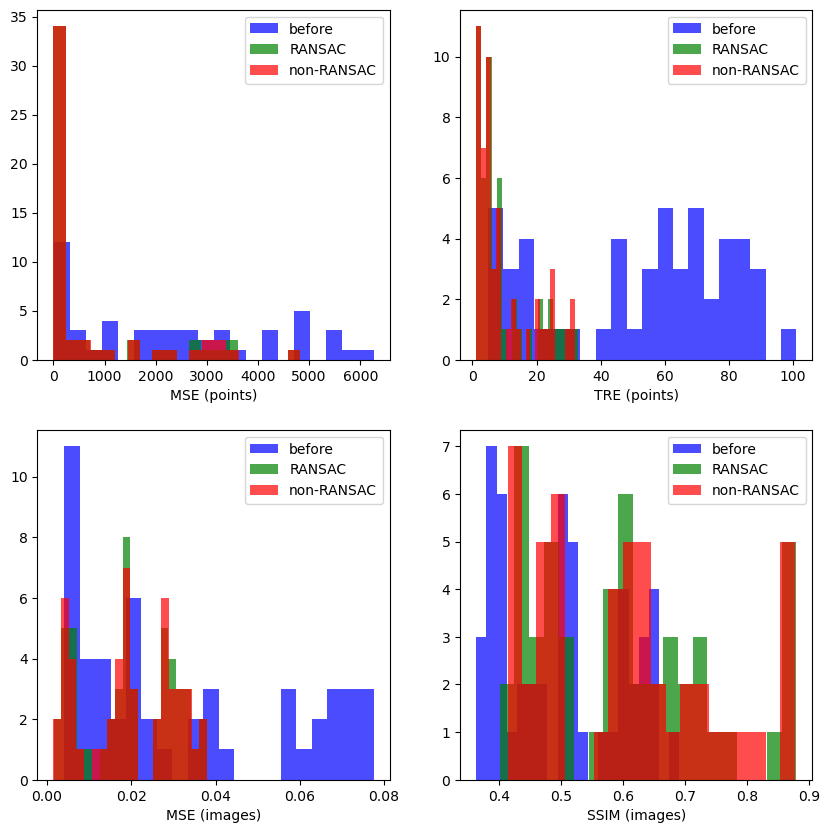

In [55]:
alpha_value = 0.7

# plot the histogram of the metrics
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(df_results['MSE before'], bins=20, color='blue', alpha=alpha_value, label='before')
plt.hist((df_results['MSE 1 to 2 RANSAC']+df_results['MSE 2 to 1 RANSAC'])/2, 
         bins=20, color='green', alpha=alpha_value, label='RANSAC')
plt.hist((df_results['MSE 1 to 2']+df_results['MSE 2 to 1'])/2, bins=20, color='red', alpha=alpha_value, label='non-RANSAC')
plt.legend()
plt.xlabel('MSE (points)')

plt.subplot(2, 2, 2)
plt.hist(df_results['TRE before'], bins=20, color='blue', alpha=alpha_value, label='before')
plt.hist((df_results['TRE 1 to 2 RANSAC']+df_results['TRE 2 to 1 RANSAC'])/2, 
         bins=20, color='green', alpha=alpha_value, label='RANSAC')
plt.hist((df_results['TRE 1 to 2']+df_results['TRE 2 to 1'])/2, bins=20, color='red', alpha=alpha_value, label='non-RANSAC')
plt.legend()
plt.xlabel('TRE (points)')

plt.subplot(2, 2, 3)
plt.hist(df_results['MSE before image'], bins=20, color='blue', alpha=alpha_value, label='before')
plt.hist((df_results['MSE 1 to 2 image RANSAC']+df_results['MSE 2 to 1 image RANSAC'])/2, 
         bins=20, color='green', alpha=alpha_value, label='RANSAC')
plt.hist((df_results['MSE 1 to 2 image']+df_results['MSE 2 to 1 image'])/2, bins=20, color='red', alpha=alpha_value, label='non-RANSAC')
plt.legend()
plt.xlabel('MSE (images)')

plt.subplot(2, 2, 4)
plt.hist(df_results['SSIM before'], bins=20, color='blue', alpha=alpha_value, label='before')
plt.hist((df_results['SSIM 1 to 2 image RANSAC']+df_results['SSIM 2 to 1 image RANSAC'])/2, bins=20, color='green', alpha=alpha_value, label='RANSAC')
plt.hist((df_results['SSIM 1 to 2 image']+df_results['SSIM 2 to 1 image'])/2, bins=20, color='red', alpha=alpha_value, label='non-RANSAC')
plt.legend()
plt.xlabel('SSIM (images)')

plt.show()